In [1]:
# Import libraries
import psycopg2
import getpass
import numpy as np
import matplotlib.pyplot as plt
import os.path
from math import floor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns

In [2]:
# Create a database connection
user = 'postgres'
host = 'localhost'
port = '5433'
dbname = 'mimic'
schema = 'mimiciii'

In [3]:
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=user, host=host, port=port, 
                       password=getpass.getpass(prompt='Password:'.format(user)))
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema))
con.commit()
print("Connected!")

Password: ··········


Connected!


In [4]:
# Query the database for the full combined dataset, for patients over 18 years old on their first admission
query = \
"""
SELECT *
FROM fulldataset
"""

# Execute the query and fetch the result
cur.execute(query)
con.commit()
data = cur.fetchall()

# Store the result of the query as a numpy array
fulldataset = np.array(data)
fulldataset = fulldataset[:,:-1] # we don't need first_admit_flag because it'll be true for every patient

# Quick sanity check
print("Shape of fulldataset: {}".format(np.shape(fulldataset)))

Shape of fulldataset: (37859, 74)


In [5]:
# Query the database for the column names
query = \
"""
SELECT attname
FROM   pg_attribute
WHERE  attrelid = 'fulldataset'::regclass
AND    attnum > 0
AND    NOT attisdropped
ORDER  BY attnum;
"""

# Execute the query and fetch the result
cur.execute(query)
con.commit()
data = cur.fetchall()

# Store the result of the query as an array
fulldataset_labels = []
for row in data:
    fulldataset_labels.append(row[0])
fulldataset_labels = fulldataset_labels[:-1] # we don't need first_admit_flag because it'll be true for every patient

# Quick sanity check
print("Shape of fulldataset_labels: {}".format(np.shape(fulldataset_labels)))
print("Column names: {}".format(fulldataset_labels))

Shape of fulldataset_labels: (74,)
Column names: ['subject_id', 'hadm_id', 'icustay_id', 'heartrate_min', 'heartrate_max', 'heartrate_mean', 'sysbp_min', 'sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max', 'diasbp_mean', 'meanbp_min', 'meanbp_max', 'meanbp_mean', 'resprate_min', 'resprate_max', 'resprate_mean', 'tempc_min', 'tempc_max', 'tempc_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_min', 'glucose_max', 'glucose_mean', 'aniongap_min', 'aniongap_max', 'albumin_min', 'albumin_max', 'bands_min', 'bands_max', 'bicarbonate_min', 'bicarbonate_max', 'bilirubin_min', 'bilirubin_max', 'creatinine_min', 'creatinine_max', 'chloride_min', 'chloride_max', 'lab_glucose_min', 'lab_glucose_max', 'hematocrit_min', 'hematocrit_max', 'hemoglobin_min', 'hemoglobin_max', 'lactate_min', 'lactate_max', 'platelet_min', 'platelet_max', 'potassium_min', 'potassium_max', 'ptt_min', 'ptt_max', 'inr_min', 'inr_max', 'pt_min', 'pt_max', 'sodium_min', 'sodium_max', 'bun_min', 'bun_max', 'wbc_min', 'w

In [6]:
# Print example for one patient
num_features = len(fulldataset_labels)
patient = 5
for i in range(num_features):
    print("{}: {}".format(fulldataset_labels[i], fulldataset[patient][i]))

subject_id: 12
hadm_id: 112213
icustay_id: 232669
heartrate_min: 71.0
heartrate_max: 105.0
heartrate_mean: 85.8285714285714
sysbp_min: 98.0
sysbp_max: 165.0
sysbp_mean: 128.228571428571
diasbp_min: 55.0
diasbp_max: 79.0
diasbp_mean: 64.8857142857143
meanbp_min: 73.0
meanbp_max: 110.0
meanbp_mean: 88.2
resprate_min: 8.0
resprate_max: 18.0
resprate_mean: 15.2380952380952
tempc_min: 35.5000008477105
tempc_max: 37.6666683620877
tempc_mean: 36.6161620014846
spo2_min: 94.0
spo2_max: 100.0
spo2_mean: 96.4838709677419
glucose_min: 79.0
glucose_max: 191.0
glucose_mean: 138.28
aniongap_min: 11.0
aniongap_max: 28.0
albumin_min: None
albumin_max: None
bands_min: None
bands_max: None
bicarbonate_min: 11.0
bicarbonate_max: 25.0
bilirubin_min: None
bilirubin_max: None
creatinine_min: 1.3
creatinine_max: 1.7
chloride_min: 111.0
chloride_max: 113.0
lab_glucose_min: 88.0
lab_glucose_max: 191.0
hematocrit_min: 23.0
hematocrit_max: 39.4
hemoglobin_min: 7.8
hemoglobin_max: 13.3
lactate_min: 2.0
lactate_max

In [7]:
# Calculate the amount of missing data for each feature
data = fulldataset[:,3:]
labels = fulldataset_labels[3:]
num_missing = np.sum(data==None,0)
m = len(data)
pct_missing = num_missing/m * 100
print("Features with more than 10% missing values:")
for feature in range(len(labels)):
    if round(pct_missing[feature],2) >= 10:
        print('{}: {}% ({}/{})'.format(labels[feature], round(pct_missing[feature],2), num_missing[feature], m))

Features with more than 10% missing values:
albumin_min: 64.64% (24472/37859)
albumin_max: 64.64% (24472/37859)
bands_min: 88.8% (33620/37859)
bands_max: 88.8% (33620/37859)
bilirubin_min: 57.16% (21642/37859)
bilirubin_max: 57.16% (21642/37859)
lactate_min: 42.19% (15971/37859)
lactate_max: 42.19% (15971/37859)
ptt_min: 11.02% (4172/37859)
ptt_max: 11.02% (4172/37859)
inr_min: 10.76% (4072/37859)
inr_max: 10.76% (4072/37859)
pt_min: 10.77% (4078/37859)
pt_max: 10.77% (4078/37859)


In [8]:
# Calculate how much data is missing for each patient (as a percentage)
num_missing = np.sum(data==None,1)
num_features = len(labels)
pct_missing = num_missing/num_features * 100
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
diff = bins[2] - bins[1]
for num in bins:
    print("Patients with {}% to {}% of features missing: {}% ({}/{})".format(num-diff, num, round((sum(pct_missing<num)-sum(pct_missing<(num-diff)))/m*100,2), sum(pct_missing<num)-sum(pct_missing<(num-diff)), m))

Patients with 0% to 10% of features missing: 66.61% (25218/37859)
Patients with 10% to 20% of features missing: 31.85% (12059/37859)
Patients with 20% to 30% of features missing: 0.67% (252/37859)
Patients with 30% to 40% of features missing: 0.29% (110/37859)
Patients with 40% to 50% of features missing: 0.15% (56/37859)
Patients with 50% to 60% of features missing: 0.41% (154/37859)
Patients with 60% to 70% of features missing: 0.03% (10/37859)
Patients with 70% to 80% of features missing: 0.0% (0/37859)
Patients with 80% to 90% of features missing: 0.0% (0/37859)
Patients with 90% to 100% of features missing: 0.0% (0/37859)


In [9]:
# Calculate how much data is missing for each patient (by no. of features)
bins = np.array(range(num_features+1))
for num in bins:
    diff = bins[2] - bins[1]
    print("Patients with {} feature{} missing: {}% ({}/{})".format(num, "" if num==1 else "s", round(sum(num_missing==num)/m*100,2), sum(num_missing==num), m))

Patients with 0 features missing: 5.27% (1997/37859)
Patients with 1 feature missing: 0.05% (18/37859)
Patients with 2 features missing: 16.44% (6224/37859)
Patients with 3 features missing: 0.18% (70/37859)
Patients with 4 features missing: 17.17% (6501/37859)
Patients with 5 features missing: 0.52% (196/37859)
Patients with 6 features missing: 26.37% (9984/37859)
Patients with 7 features missing: 0.6% (228/37859)
Patients with 8 features missing: 19.68% (7450/37859)
Patients with 9 features missing: 1.48% (559/37859)
Patients with 10 features missing: 2.74% (1038/37859)
Patients with 11 features missing: 0.46% (175/37859)
Patients with 12 features missing: 3.3% (1250/37859)
Patients with 13 features missing: 0.22% (85/37859)
Patients with 14 features missing: 3.97% (1502/37859)
Patients with 15 features missing: 0.13% (49/37859)
Patients with 16 features missing: 0.17% (64/37859)
Patients with 17 features missing: 0.13% (50/37859)
Patients with 18 features missing: 0.12% (44/37859)
P

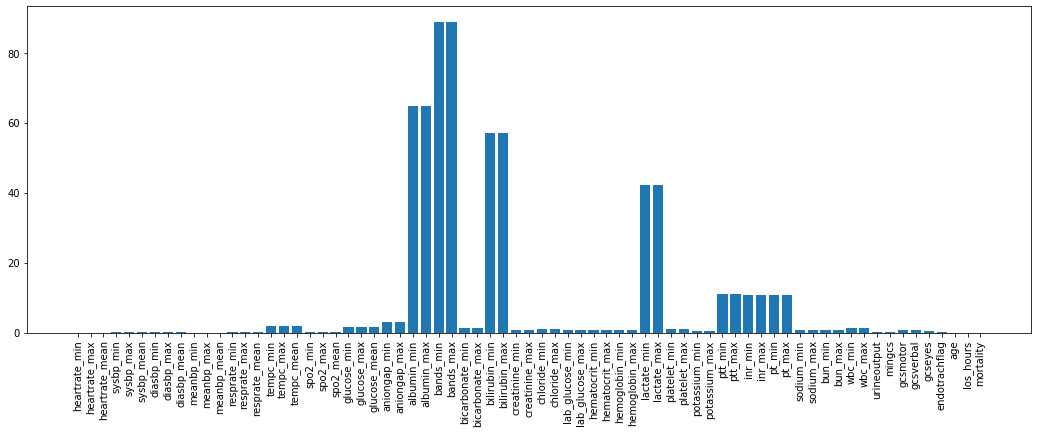

In [10]:
# Plot bar chart to illustrate missing data
x = np.arange(len(fulldataset_labels[3:]))
num_missing = np.sum(data==None,0)
m = len(data)
pct_missing = num_missing/m * 100
cleaned_x = x[pct_missing<10]
cleaned_labels = []
for i in range(len(cleaned_x)):
    cleaned_labels.append(labels[cleaned_x[i]])
cleaned_pct_missing = pct_missing[pct_missing<10]
fig = plt.figure(figsize=(18,6))
plt.bar(x, pct_missing)
plt.xticks(x, labels, rotation='vertical')
plt.show()

In [11]:
# Remove all features with >10% missing data
cleaned_data = data[:,pct_missing<=10]

# Calculate how much data is missing for each patient (by no. of features)
num_missing = np.sum(cleaned_data==None,1)
num_features = len(cleaned_labels)
bins = np.array(range(num_features+1))
for num in bins:
    diff = bins[2] - bins[1]
    print("Patients with {} feature{} missing: {}% ({}/{})".format(num, "" if num==1 else "s", round(sum(num_missing==num)/m*100,2), sum(num_missing==num), m))

Patients with 0 features missing: 92.37% (34969/37859)
Patients with 1 feature missing: 0.72% (271/37859)
Patients with 2 features missing: 2.05% (775/37859)
Patients with 3 features missing: 2.74% (1037/37859)
Patients with 4 features missing: 0.38% (145/37859)
Patients with 5 features missing: 0.14% (53/37859)
Patients with 6 features missing: 0.27% (103/37859)
Patients with 7 features missing: 0.16% (62/37859)
Patients with 8 features missing: 0.28% (105/37859)
Patients with 9 features missing: 0.03% (11/37859)
Patients with 10 features missing: 0.13% (48/37859)
Patients with 11 features missing: 0.03% (13/37859)
Patients with 12 features missing: 0.03% (12/37859)
Patients with 13 features missing: 0.01% (2/37859)
Patients with 14 features missing: 0.03% (12/37859)
Patients with 15 features missing: 0.03% (11/37859)
Patients with 16 features missing: 0.01% (5/37859)
Patients with 17 features missing: 0.05% (20/37859)
Patients with 18 features missing: 0.0% (0/37859)
Patients with 19

In [12]:
# Extract a dense dataset and split into test and train sets
dense_data = cleaned_data[num_missing==0,:]

# Randomly shuffle the newly created dense dataset
np.random.shuffle(dense_data)

# Split the data into training and test set
m = len(dense_data)
train_split, test_split = m*0.85, m*0.15 # make sure these numbers sum to m*1.0
train, test = \
    dense_data[:floor(train_split),:], \
    dense_data[floor(train_split):,:]

# Create input (X) and output (Y) arrays
X_train_dense, X_test_dense = train[:,:-1], test[:,:-1]
Y_train_dense, Y_test_dense = train[:,-1], test[:,-1]

In [13]:
# Print information about the created arrays
print("No. of patients: {}".format(len(dense_data)))
print("No. of features: {}".format(X_train_dense.shape[1]))
print("No. of patients in train and test sets: {}, {}".format(len(X_train_dense), len(X_test_dense)))
print("No. of patients who died in hospital in train and test sets: {}, {}".format(sum(Y_train_dense), sum(Y_test_dense)))
print("Proportion of patients who died in hospital in train and test sets: {}%, {}%".format(round(sum(Y_train_dense)/len(Y_train_dense)*100,3), round(sum(Y_test_dense)/len(Y_test_dense)*100,3)))

No. of patients: 34969
No. of features: 56
No. of patients in train and test sets: 29723, 5246
No. of patients who died in hospital in train and test sets: 3230, 582
Proportion of patients who died in hospital in train and test sets: 10.867%, 11.094%


In [14]:
# Convert all data to floats
X_train_dense = X_train_dense.astype(float)
Y_train_dense = Y_train_dense.astype(float)
X_test_dense = X_test_dense.astype(float)
Y_test_dense = Y_test_dense.astype(float)

In [15]:
# Create decision tree classifer object
decisionTree = DecisionTreeClassifier()

# Train decision tree classifer
decisionTree = decisionTree.fit(X_train_dense,Y_train_dense)

# Predict the response for test dataset
Y_pred = decisionTree.predict(X_test_dense)

In [16]:
# Show metrics for decision tree classifier
print("Metrics for decision tree classifier:")
print("")
print(metrics.classification_report(Y_test_dense, Y_pred, target_names = ["Survived", "Died"]))

Metrics for decision tree classifier:

              precision    recall  f1-score   support

    Survived       0.92      0.92      0.92      4664
        Died       0.37      0.38      0.38       582

    accuracy                           0.86      5246
   macro avg       0.65      0.65      0.65      5246
weighted avg       0.86      0.86      0.86      5246



In [17]:
# Show AUROC for decision tree classifier
print("AUROC for decision tree classifier:")
print("")
print(metrics.roc_auc_score(Y_test_dense, Y_pred))

AUROC for decision tree classifier:

0.6503056975119803


In [18]:
# Create logistic regression classifer object
logisticRegr = LogisticRegression(solver = "liblinear", max_iter = 10000)

# Train logistic regression classifer
logisticRegr.fit(X_train_dense, Y_train_dense)

# Predict the response for test dataset
Y_pred = logisticRegr.predict(X_test_dense)

In [19]:
# Show metrics for logistic regression classifier
print("Metrics for logistic regression classifier:")
print("")
print(metrics.classification_report(Y_test_dense, Y_pred, target_names = ["Survived", "Died"]))

Metrics for logistic regression classifier:

              precision    recall  f1-score   support

    Survived       0.91      0.98      0.95      4664
        Died       0.67      0.26      0.38       582

    accuracy                           0.90      5246
   macro avg       0.79      0.62      0.66      5246
weighted avg       0.89      0.90      0.88      5246



In [20]:
# Show AUROC for logistic regression classifier
print("AUROC for logistic regression classifier:")
print("")
print(metrics.roc_auc_score(Y_test_dense, Y_pred))

AUROC for logistic regression classifier:

0.6241548926337878


In [21]:
# Resample a balanced dataset
survived = dense_data[dense_data[:,-1]==0]
died = dense_data[dense_data[:,-1]==1]

np.random.shuffle(survived)

survived = survived[:len(died),:]

data = np.concatenate((survived,died))

print(np.shape(survived))
print(np.shape(died))
print(np.shape(data))

(3812, 57)
(3812, 57)
(7624, 57)


In [22]:
# Randomly shuffle the newly created dense dataset
np.random.shuffle(data)

# Split the data into training and test set
m = len(data)
train_split, test_split = m*0.85, m*0.15 # make sure these numbers sum to m*1.0
train, test = \
    data[:floor(train_split),:], \
    data[floor(train_split):,:]

# Create input (X) and output (Y) arrays
X_train_dense, X_test_dense = train[:,:-1], test[:,:-1]
Y_train_dense, Y_test_dense = train[:,-1], test[:,-1]

In [23]:
# Print information about the created arrays
print("No. of patients: {}".format(len(data)))
print("No. of features: {}".format(X_train_dense.shape[1]))
print("No. of patients in train and test sets: {}, {}".format(len(X_train_dense), len(X_test_dense)))
print("No. of patients who died in hospital in train and test sets: {}, {}".format(sum(Y_train_dense), sum(Y_test_dense)))
print("Proportion of patients who died in hospital in train and test sets: {}%, {}%".format(round(sum(Y_train_dense)/len(Y_train_dense)*100,3), round(sum(Y_test_dense)/len(Y_test_dense)*100,3)))

No. of patients: 7624
No. of features: 56
No. of patients in train and test sets: 6480, 1144
No. of patients who died in hospital in train and test sets: 3223, 589
Proportion of patients who died in hospital in train and test sets: 49.738%, 51.486%


In [24]:
# Convert all data to floats
X_train_dense = X_train_dense.astype(float)
Y_train_dense = Y_train_dense.astype(float)
X_test_dense = X_test_dense.astype(float)
Y_test_dense = Y_test_dense.astype(float)

In [25]:
# Create decision tree classifer object
decisionTree = DecisionTreeClassifier()

# Train decision tree classifer
decisionTree = decisionTree.fit(X_train_dense,Y_train_dense)

# Predict the response for test dataset
Y_pred = decisionTree.predict(X_test_dense)

In [26]:
# Show metrics for decision tree classifier
print("Metrics for decision tree classifier:")
print("")
print(metrics.classification_report(Y_test_dense, Y_pred, target_names = ["Survived", "Died"]))

Metrics for decision tree classifier:

              precision    recall  f1-score   support

    Survived       0.69      0.74      0.71       555
        Died       0.74      0.68      0.71       589

    accuracy                           0.71      1144
   macro avg       0.71      0.71      0.71      1144
weighted avg       0.71      0.71      0.71      1144



In [27]:
# Show AUROC for decision tree classifier
print("AUROC for decision tree classifier:")
print("")
print(metrics.roc_auc_score(Y_test_dense, Y_pred))

AUROC for decision tree classifier:

0.7098288441242601


In [28]:
# Create logistic regression classifer object
logisticRegr = LogisticRegression(solver = "liblinear", max_iter = 10000)

# Train logistic regression classifer
logisticRegr.fit(X_train_dense, Y_train_dense)

# Predict the response for test dataset
Y_pred = logisticRegr.predict(X_test_dense)

In [29]:
# Show metrics for logistic regression classifier
print("Metrics for logistic regression classifier:")
print("")
print(metrics.classification_report(Y_test_dense, Y_pred, target_names = ["Survived", "Died"]))

Metrics for logistic regression classifier:

              precision    recall  f1-score   support

    Survived       0.75      0.81      0.78       555
        Died       0.81      0.75      0.77       589

    accuracy                           0.78      1144
   macro avg       0.78      0.78      0.78      1144
weighted avg       0.78      0.78      0.78      1144



In [30]:
# Show AUROC for logistic regression classifier
print("AUROC for logistic regression classifier:")
print("")
print(metrics.roc_auc_score(Y_test_dense, Y_pred))

AUROC for logistic regression classifier:

0.7780709402101592


In [31]:
metrics.confusion_matrix(Y_test_dense, Y_pred)

array([[450, 105],
       [150, 439]], dtype=int64)